# Video Classification with a CNN-RNN Architecture



This project is about video classification for Action Recognition using UFC101 dataset (https://www.crcv.ucf.edu/data/UCF101.php)

The dataset consists of videos categorized into different
actions, like cricket shot, punching, biking, etc. This dataset is commonly used to train AI models to classify videos for the purpose of action recognition

A video consists of an ordered sequence of frames. Each frame contains spatial
information, and the sequence of those frames contains temporal information. To consider both of these aspects, we use a hybrid architecture that consists of convolutions (for spatial processing) as well as recurrent layers (for temporal processing).

To be more specific, we will use a Convolutional Neural Network (CNN) (a pretrained VGG16 CNN model) and a Recurrent Neural
Network (RNN) consisting of Hi Dim LSTM layers 

This kind of hybrid architecture is commonly known as a CNN-RNN

This example requires TensorFlow 2.5 or higher, as well as TensorFlow Docs, which can be
installed using the following command:

In [59]:
!pip install -q git+https://github.com/tensorflow/docs

## Data collection

In order to keep the runtime of this example relatively short, we will be using a
subsampled version of the original UCF101 dataset. You can refer to
[this notebook](https://colab.research.google.com/github/sayakpaul/Action-Recognition-in-TensorFlow/blob/main/Data_Preparation_UCF101.ipynb)
to know how the subsampling was done.

In [73]:
!wget -q --no-check-certificate https://www.crcv.ucf.edu/data/UCF101/UCF101.rar
!wget -q --no-check-certificate https://www.crcv.ucf.edu/data/UCF101/UCF101TrainTestSplits-RecognitionTask.zip



In [75]:
%%capture
!unrar e UCF101.rar data/
!unzip -qq UCF101TrainTestSplits-RecognitionTask.zip

In [72]:
from imutils import paths
from tqdm import tqdm
import pandas as pd 
import numpy as np
import shutil
import cv2
import os

#Metadara loading

# Open the .txt file which have names of training videos
f = open("ucfTrainTestlist/trainlist01.txt", "r")
temp = f.read()
videos = temp.split('\n')

# Create a dataframe having video names
train = pd.DataFrame()
train['video_name'] = videos
train = train[:-1]
train.head()


,video_name
0,ApplyEyeMakeup/v_ApplyEyeMakeup_g08_c01.avi 1
1,ApplyEyeMakeup/v_ApplyEyeMakeup_g08_c02.avi 1
2,ApplyEyeMakeup/v_ApplyEyeMakeup_g08_c03.avi 1
3,ApplyEyeMakeup/v_ApplyEyeMakeup_g08_c04.avi 1
4,ApplyEyeMakeup/v_ApplyEyeMakeup_g08_c05.avi 1


In [63]:
# Open the .txt file which have names of test videos
with open("ucfTrainTestlist/testlist01.txt", "r") as f:
    temp = f.read()
videos = temp.split("\n")

# Create a dataframe having video names
test = pd.DataFrame()
test["video_name"] = videos
test = test[:-1]
test.head()

,video_name
0,ApplyEyeMakeup/v_ApplyEyeMakeup_g01_c01.avi
1,ApplyEyeMakeup/v_ApplyEyeMakeup_g01_c02.avi
2,ApplyEyeMakeup/v_ApplyEyeMakeup_g01_c03.avi
3,ApplyEyeMakeup/v_ApplyEyeMakeup_g01_c04.avi
4,ApplyEyeMakeup/v_ApplyEyeMakeup_g01_c05.avi


In [64]:
#Utility Functions

def extract_tag(video_path):
    return video_path.split("/")[0]

def separate_video_name(video_name):
    return video_name.split("/")[1]

def rectify_video_name(video_name):
    return video_name.split(" ")[0]

def move_videos(df, output_dir):
    if not os.path.exists(output_dir):
        os.mkdir(output_dir)
    for i in tqdm(range(df.shape[0])):
        videoFile = df['video_name'][i].split("/")[-1]
        videoPath = os.path.join("data", videoFile)
        shutil.copy2(videoPath, output_dir)
    print()
    print(f"Total videos: {len(os.listdir(output_dir))}")

    

In [65]:
#Dataframe preparation

train["tag"] = train["video_name"].apply(extract_tag)
train["video_name"] = train["video_name"].apply(separate_video_name)
train.head()

,video_name,tag
0,v_ApplyEyeMakeup_g08_c01.avi 1,ApplyEyeMakeup
1,v_ApplyEyeMakeup_g08_c02.avi 1,ApplyEyeMakeup
2,v_ApplyEyeMakeup_g08_c03.avi 1,ApplyEyeMakeup
3,v_ApplyEyeMakeup_g08_c04.avi 1,ApplyEyeMakeup
4,v_ApplyEyeMakeup_g08_c05.avi 1,ApplyEyeMakeup


In [66]:
train["video_name"] = train["video_name"].apply(rectify_video_name)
train.head()

,video_name,tag
0,v_ApplyEyeMakeup_g08_c01.avi,ApplyEyeMakeup
1,v_ApplyEyeMakeup_g08_c02.avi,ApplyEyeMakeup
2,v_ApplyEyeMakeup_g08_c03.avi,ApplyEyeMakeup
3,v_ApplyEyeMakeup_g08_c04.avi,ApplyEyeMakeup
4,v_ApplyEyeMakeup_g08_c05.avi,ApplyEyeMakeup


In [67]:
test["tag"] = test["video_name"].apply(extract_tag)
test["video_name"] = test["video_name"].apply(separate_video_name)
test.head()

,video_name,tag
0,v_ApplyEyeMakeup_g01_c01.avi,ApplyEyeMakeup
1,v_ApplyEyeMakeup_g01_c02.avi,ApplyEyeMakeup
2,v_ApplyEyeMakeup_g01_c03.avi,ApplyEyeMakeup
3,v_ApplyEyeMakeup_g01_c04.avi,ApplyEyeMakeup
4,v_ApplyEyeMakeup_g01_c05.avi,ApplyEyeMakeup


## Filtering Top-n Actions

In [68]:
n = 5
topNActs = train["tag"].value_counts().nlargest(n).reset_index()["index"].tolist()
train_new = train[train["tag"].isin(topNActs)]
test_new = test[test["tag"].isin(topNActs)]
train_new.shape, test_new.shape

((594, 2), (218, 2))

In [69]:
train_new = train_new.reset_index(drop=True)
test_new = test_new.reset_index(drop=True)

In [76]:
move_videos(train_new, "train")
move_videos(test_new, "test")

train_new.to_csv("train.csv", index=False)
test_new.to_csv("test.csv", index=False)



## Setup

In [ ]:
from tensorflow_docs.vis import embed
from tensorflow import keras
from imutils import paths

import matplotlib.pyplot as plt
import tensorflow as tf
import pandas as pd
import numpy as np
import imageio
import cv2
import os

## Define hyperparameters

In [ ]:
IMG_SIZE = 224
BATCH_SIZE = 64
EPOCHS = 10

MAX_SEQ_LENGTH = 20
NUM_FEATURES = 512

## Data preparation

In [ ]:
train_df = pd.read_csv("train.csv")
test_df = pd.read_csv("test.csv")

print(f"Total videos for training: {len(train_df)}")
print(f"Total videos for testing: {len(test_df)}")

train_df.sample(10)

Total videos for training: 594
Total videos for testing: 224


,video_name,tag
516,v_TennisSwing_g13_c06.avi,TennisSwing
49,v_CricketShot_g15_c01.avi,CricketShot
53,v_CricketShot_g15_c05.avi,CricketShot
320,v_Punch_g20_c01.avi,Punch
170,v_PlayingCello_g16_c01.avi,PlayingCello
54,v_CricketShot_g15_c06.avi,CricketShot
36,v_CricketShot_g13_c02.avi,CricketShot
165,v_PlayingCello_g15_c03.avi,PlayingCello
475,v_ShavingBeard_g25_c05.avi,ShavingBeard
377,v_ShavingBeard_g10_c05.avi,ShavingBeard


One main challange we face in using videos for deep learning is to find a method to input the videos to the network.

As we know that a video is an ordered sequence of frames, we can extract the frames and place the frames in a tensor, more specifically a 3D tensor.

However, each video could have different number of frames, which could cause issues when we try to stack them into batches for training our model, unless we use something like padding. 

Another way which we are going to use is saving the frames of videos at a fixed interval till we reach maximum frame count. 

To put it all together, we will do the below steps:

1. We will capture or take the frames of a video.
2. We will then extract the frames from the videos till the point where we reach  maximum frame count. 

3. As mentioned above, not all videos will have the same frame count. Hence for the videos will frames less than the maximum frame count, we will pad those videos with zeroes to make sure the length is the same

In [ ]:
# The following two methods are taken from this tutorial:
# https://www.tensorflow.org/hub/tutorials/action_recognition_with_tf_hub


def crop_center_square(frame):
    y, x = frame.shape[0:2]
    min_dim = min(y, x)
    start_x = (x // 2) - (min_dim // 2)
    start_y = (y // 2) - (min_dim // 2)
    return frame[start_y : start_y + min_dim, start_x : start_x + min_dim]


def load_video(path, max_frames=0, resize=(IMG_SIZE, IMG_SIZE)):
    cap = cv2.VideoCapture(path)
    frames = []
    try:
        while True:
            ret, frame = cap.read()
            if not ret:
                break
            frame = crop_center_square(frame)
            frame = cv2.resize(frame, resize)
            frame = frame[:, :, [2, 1, 0]]
            frames.append(frame)

            if len(frames) == max_frames:
                break
    finally:
        cap.release()
    return np.array(frames)


We use a pretrained CNN model called VGG16 for extracting useful features from the frames. The CNN model was pretrained on the popular ImageNet dataset

In [ ]:

def build_feature_extractor():
    feature_extractor = keras.applications.vgg16.VGG16(
        weights="imagenet",
        include_top=False,
        pooling="avg",
        input_shape=(IMG_SIZE, IMG_SIZE, 3),
    )
    preprocess_input = keras.applications.vgg16.preprocess_input

    inputs = keras.Input((IMG_SIZE, IMG_SIZE, 3))
    preprocessed = preprocess_input(inputs)

    outputs = feature_extractor(preprocessed)
    return keras.Model(inputs, outputs, name="feature_extractor")


feature_extractor = build_feature_extractor()

58889256/58889256 [==============================] - 0s 0us/step


Now since the UCF101 dataset has the video labels in text form, we need to convert them to numeric form for the model to understand as machine or deep learning models do not understand strings. Here we make use of a stringlookup layer of keras library to convert the video labels to integers

In [ ]:
label_processor = keras.layers.StringLookup(
    num_oov_indices=0, vocabulary=np.unique(train_df["tag"])
)
print(label_processor.get_vocabulary())

['CricketShot', 'PlayingCello', 'Punch', 'ShavingBeard', 'TennisSwing']


Finally, we can put all the pieces together to create our data processing utility.

In [ ]:

def prepare_all_videos(df, root_dir):
    num_samples = len(df)
    video_paths = df["video_name"].values.tolist()
    labels = df["tag"].values
    labels = label_processor(labels[..., None]).numpy()

    # `frame_masks` and `frame_features` are what we will feed to our sequence model.
    # `frame_masks` will contain a bunch of booleans denoting if a timestep is
    # masked with padding or not.
    frame_masks = np.zeros(shape=(num_samples, MAX_SEQ_LENGTH), dtype="bool")
    frame_features = np.zeros(
        shape=(num_samples, MAX_SEQ_LENGTH, NUM_FEATURES), dtype="float32"
    )

    # For each video.
    for idx, path in enumerate(video_paths):
        # Gather all its frames and add a batch dimension.
        frames = load_video(os.path.join(root_dir, path))
        frames = frames[None, ...]

        # Initialize placeholders to store the masks and features of the current video.
        temp_frame_mask = np.zeros(shape=(1, MAX_SEQ_LENGTH,), dtype="bool")
        temp_frame_features = np.zeros(
            shape=(1, MAX_SEQ_LENGTH, NUM_FEATURES), dtype="float32"
        )

        # Extract features from the frames of the current video.
        for i, batch in enumerate(frames):
            video_length = batch.shape[0]
            length = min(MAX_SEQ_LENGTH, video_length)
            for j in range(length):
                temp_frame_features[i, j, :] = feature_extractor.predict(
                    batch[None, j, :]
                )
            temp_frame_mask[i, :length] = 1  # 1 = not masked, 0 = masked

        frame_features[idx,] = temp_frame_features.squeeze()
        frame_masks[idx,] = temp_frame_mask.squeeze()

    return (frame_features, frame_masks), labels


train_data, train_labels = prepare_all_videos(train_df, "train")
test_data, test_labels = prepare_all_videos(test_df, "test")

print(f"Frame features in train set: {train_data[0].shape}")
print(f"Frame masks in train set: {train_data[1].shape}")

Streaming output truncated to the last 5000 lines.
1/1 [==============================] - 1s 500ms/step
Frame features in train set: (594, 20, 512)
Frame masks in train set: (594, 20)


The above code block will take ~20 minutes to execute depending on the machine it's being
executed.

## The sequence model

Now, we can feed this data to a sequence model consisting of recurrent layers like hi dim LSTM.

In [ ]:
# from keras import backend as K

# def recall_m(y_true, y_pred):
#     true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
#     possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
#     recall = true_positives / (possible_positives + K.epsilon())
#     return recall

# def precision_m(y_true, y_pred):
#     true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
#     predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
#     precision = true_positives / (predicted_positives + K.epsilon())
#     return precision

# def f1_m(y_true, y_pred):
#     precision = precision_m(y_true, y_pred)
#     recall = recall_m(y_true, y_pred)
#     return 2*((precision*recall)/(precision+recall+K.epsilon()))



In [ ]:
import random
import numpy as np
import tensorflow as tf
random.seed(1)
np.random.seed(1)
tf.random.set_seed(1)

# Utility for our sequence model.
def get_sequence_model():
    class_vocab = label_processor.get_vocabulary()

    frame_features_input = keras.Input((MAX_SEQ_LENGTH, NUM_FEATURES))
    mask_input = keras.Input((MAX_SEQ_LENGTH,), dtype="bool")

    x = keras.layers.LSTM(456, return_sequences=True, go_backwards=False, stateful=False,
                          unroll=False, activation='tanh', recurrent_activation='hard_sigmoid', use_bias=True, 
                          kernel_initializer={"class_name": "VarianceScaling", "config": {"scale": 1.0, "mode": "fan_avg", "distribution": 
            "uniform", "seed": None}}, recurrent_initializer= {"class_name": "Orthogonal", "config": {"gain": 1.0, 
                "seed": None}}, bias_initializer= {"class_name": "Zeros", "config": {}}, unit_forget_bias= True,
            kernel_regularizer= None, recurrent_regularizer= None, bias_regularizer=None,
                     activity_regularizer=None, kernel_constraint=None, recurrent_constraint= None, 
                     bias_constraint= None, dropout= 0.5, recurrent_dropout= 0.0, 
                     implementation= 1)(
        frame_features_input, mask=mask_input
    )
    x = keras.layers.LSTM(8)(x)
    x = keras.layers.Dropout(0.4)(x)
    x = keras.layers.Dense(8, activation="relu")(x)
    output = keras.layers.Dense(len(class_vocab), activation="softmax")(x)

    rnn_model = keras.Model([frame_features_input, mask_input], output)

    rnn_model.compile(
        loss="sparse_categorical_crossentropy", optimizer="adam", metrics=["accuracy"]
    )
    return rnn_model


# Utility for running experiments.
def run_experiment():
    filepath = "/tmp/video_classifier"
    checkpoint = keras.callbacks.ModelCheckpoint(
        filepath, save_weights_only=True, save_best_only=True, verbose=1
    )

    seq_model = get_sequence_model()
    history = seq_model.fit(
        [train_data[0], train_data[1]],
        train_labels,
        validation_split=0.1,
        epochs=EPOCHS,
        callbacks=[checkpoint],
    )

    seq_model.load_weights(filepath)
    _, accuracy = seq_model.evaluate([test_data[0], test_data[1]], test_labels)
    from sklearn.metrics import classification_report
    from sklearn.metrics import f1_score, precision_score, recall_score, confusion_matrix

    y_pred = seq_model.predict([test_data[0], test_data[1]], batch_size=64, verbose=1)
    y_pred_bool = np.argmax(y_pred, axis=1)



    # evaluate the model
    print(f"Test accuracy: {round(accuracy * 100, 2)}%")

    #print classification_report
    print('Classification_report (Precision Recall F1 Score')
    print(classification_report(test_labels, y_pred_bool))

    from sklearn.metrics import precision_recall_curve
    precision, recall, thresholds = precision_recall_curve(test_labels, y_pred_bool)

    print(f"Test Precision: {round(precision_score(test_labels, y_pred_bool, average='weighted') * 100, 2)}%")

    print(f"Test Recall: {round(recall_score(test_labels, y_pred_bool, average='weighted') * 100, 2)}%")

    print(f"Test F1 Score: {round(f1_score(test_labels, y_pred_bool, average='weighted') * 100, 2)}%")

    return history, seq_model, precision, recall


_, sequence_model, precision, recall = run_experiment()

Epoch 1/10
17/17 [==============================] - ETA: 0s - loss: 1.2171 - accuracy: 0.5936
Epoch 1: val_loss improved from inf to 0.98528, saving model to /tmp/video_classifier
17/17 [==============================] - 17s 616ms/step - loss: 1.2171 - accuracy: 0.5936 - val_loss: 0.9853 - val_accuracy: 0.1500
Epoch 2/10
17/17 [==============================] - ETA: 0s - loss: 0.9360 - accuracy: 0.7453
Epoch 2: val_loss improved from 0.98528 to 0.58387, saving model to /tmp/video_classifier
17/17 [==============================] - 9s 515ms/step - loss: 0.9360 - accuracy: 0.7453 - val_loss: 0.5839 - val_accuracy: 0.9667
Epoch 3/10
17/17 [==============================] - ETA: 0s - loss: 0.8058 - accuracy: 0.7996
Epoch 3: val_loss did not improve from 0.58387
17/17 [==============================] - 9s 511ms/step - loss: 0.8058 - accuracy: 0.7996 - val_loss: 0.7224 - val_accuracy: 0.7667
Epoch 4/10
17/17 [==============================] - ETA: 0s - loss: 0.7125 - accuracy: 0.8558
Epoch 4




```

## Individual Example

Test video path: v_ShavingBeard_g02_c05.avi
1/1 [==============================] - 0s 68ms/step
  ShavingBeard: 85.45%
  PlayingCello:  6.89%
  Punch:  5.36%
  CricketShot:  1.29%
  TennisSwing:  1.01%



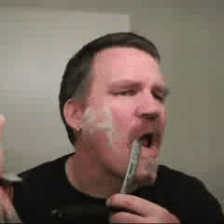

In [ ]:

def prepare_single_video(frames):
    frames = frames[None, ...]
    frame_mask = np.zeros(shape=(1, MAX_SEQ_LENGTH,), dtype="bool")
    frame_features = np.zeros(shape=(1, MAX_SEQ_LENGTH, NUM_FEATURES), dtype="float32")

    for i, batch in enumerate(frames):
        video_length = batch.shape[0]
        length = min(MAX_SEQ_LENGTH, video_length)
        for j in range(length):
            frame_features[i, j, :] = feature_extractor.predict(batch[None, j, :])
        frame_mask[i, :length] = 1  # 1 = not masked, 0 = masked

    return frame_features, frame_mask


def sequence_prediction(path):
    class_vocab = label_processor.get_vocabulary()

    frames = load_video(os.path.join("test", path))
    frame_features, frame_mask = prepare_single_video(frames)
    probabilities = sequence_model.predict([frame_features, frame_mask])[0]

    for i in np.argsort(probabilities)[::-1]:
        print(f"  {class_vocab[i]}: {probabilities[i] * 100:5.2f}%")
    return frames


# This utility is for visualization.
# Referenced from:
# https://www.tensorflow.org/hub/tutorials/action_recognition_with_tf_hub
def to_gif(images):
    converted_images = images.astype(np.uint8)
    imageio.mimsave("animation.gif", converted_images, fps=10)
    return embed.embed_file("animation.gif")


test_video = np.random.choice(test_df["video_name"].values.tolist())
print(f"Test video path: {test_video}")
test_frames = sequence_prediction(test_video)
to_gif(test_frames[:MAX_SEQ_LENGTH])

In [ ]:
pd.DataFrame([train_data]).to_csv('m_train_data.csv')
pd.DataFrame([test_data]).to_csv('m_test_data.csv')
pd.DataFrame(train_labels, columns=['train_labels']).to_csv('train_labels.csv')
pd.DataFrame(test_labels, columns=['test_labels']).to_csv('test_labels.csv')


In [ ]:
#Precision Recall Curve
import matplotlib.pyplot as plt

#create precision recall curve
fig, ax = plt.subplots()
ax.plot(recall, precision, color='purple')

#add axis labels to plot
ax.set_title('Precision-Recall Curve')
ax.set_ylabel('Precision')
ax.set_xlabel('Recall')

#display plot
plt.show()
